# Neural Style Transfer: Painting Chicago like Van Gogh

#### Garrett McCue

![starry-night](images/styles/starry-night-vincent-van-gogh.jpeg)

INTRO

Import necessary libraries

In [12]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import matplotlib.pyplot as plt
import matplotlib as mpl

# fix image format in matplotlib
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

Function for converting a tensor to an image after stylization in order to save and view the image.

In [13]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

Set paths to both the content and style images that we will use.

In [14]:
# paths to content and style images
content_path = 'images/content/chicago-skyline.jpeg'
style_path = 'images/styles/starry-night-vincent-van-gogh.jpeg'


Create a function for loading images and limiting the dimensions to 512 pixels.

In [15]:
def load_img(path_to_img):

    max_dim = 512
    
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim/long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]

    return img

Now we will create a function for visulaizing both the content and style images so we can see both before we apply the neural style transfering from the style image onto the content image. 

In [16]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

Using the `load_img()` and `imshow()` functions we just created we can visualize both content and style images

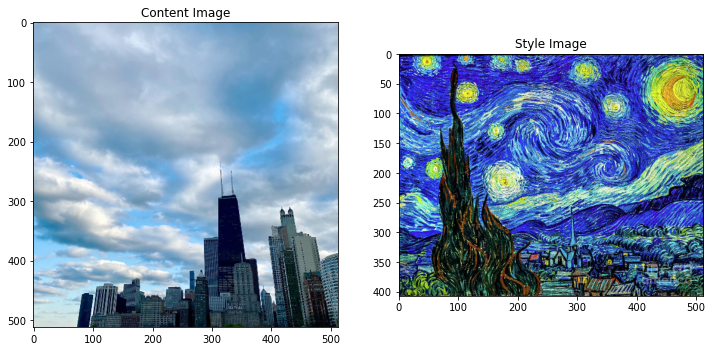

In [17]:
content_img = load_img(content_path)
style_img = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_img, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_img, 'Style Image')

## Fast Style Transfer using Tensorflow Hub

We can quickly apply the stylization to the content image using tensorflow hubs arbitrary image style transfer model. 

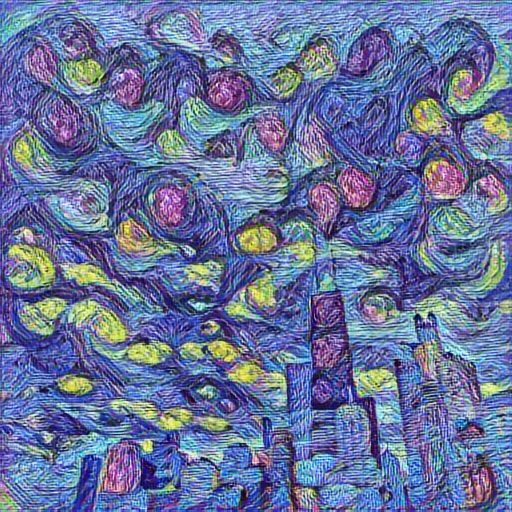

In [18]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_img), tf.constant(style_img))[0]
tensor_to_image(stylized_image).save("chicago-starry-night-fas.jpeg")

tensor_to_image(stylized_image)



The computed stylized image using Tensorflow Hub captures the general theme of the style image as a whole really well for how quick and easy it was to construct, but the edges off the buildings as well as the coloration is not as good as I think it could be. The buildings seem to be getting lost within the sky, whereas in Van Gogh's Starry Night, we can clearly make out the separation between the village and the sky/mountians in the background. 

The application of pretrained CNN architectures can be used in order to gain better stylization results, but the tradeoff is that it cannot be built as fast as we just did above. This can be done through the extraction of intermediate layers from the model for a more fine tuned and optimized "painting" with respect to the content and style images. 

Since we have come this far, we might as well shoot for the stars to see if we can really paint like Van Gogh with a little more code.

 
In order to fine tune this stylized image with the goal to maintain more of the original content image and "paint" more like Van Gogh we are going to build a transfer model using the VGG19 network architecture. 

We will now load the VGG19 model with pretained weights..

In [19]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


We will create a list of intermediate layers from the VGG19 architecture to represent the style and content of the images. For the content image we only need one of the final layers in order to represent the entire image. The style image we will use multiple layers from different depths of the network, because it is necessary to learn the stylization at lower level features such as edges and lines all the way up to higher order features such as entire objects within the style image. Including layers of differening depths from the architecure is important since the larger objects in the images are built from the learned lower level features that occur early in the network. This allows for us to stylize the content image at a lower level all the way up to the higher order features.

In [20]:

content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)

num__style_layers = len(style_layers)

print(f'content layers: {content_layers}')
print(f'style layers: {style_layers}')

content layers: ['block5_conv2']
style layers: ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


## Build the Model
create a function to build the VGG19 model loading the pretrained weights learned from the imagenet dataset. We will set `include_top = False` because the goal is not to classify the image with the fully connected network once its processed by the Convolutional layers. We will also set `trainable=False` in order to freeze all layers of the model, that way this is an application of transfer learning

In [22]:
def vgg_layers(layer_names):
    '''Creates a vgg model that returns a list of intermediate layers as the output '''
    # Load the pretrained vgg model & weights which was trained on the imagenet dataset 
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)

    return model


using `vgg_layers()` and the specified lists of layers we will create the model for extracting the style from the style image.

In [24]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_img*255)

# view the stats for each output layer
for name, output in zip(style_layers, style_outputs):
    print(f'{name}::  shape: {output.numpy().shape}')
    print(f'  min:  {output.numpy().min()}')
    print(f'  max:  {output.numpy().max()}')
    print(f'  mean: {output.numpy().mean()}\n')

block1_conv1::  shape: (1, 407, 512, 64)
  min:  0.0
  max:  824.8861694335938
  mean: 38.9649772644043

block2_conv1::  shape: (1, 203, 256, 128)
  min:  0.0
  max:  5033.9716796875
  mean: 235.70703125

block3_conv1::  shape: (1, 101, 128, 256)
  min:  0.0
  max:  8758.8232421875
  mean: 240.88519287109375

block4_conv1::  shape: (1, 50, 64, 512)
  min:  0.0
  max:  20423.587890625
  mean: 851.0270385742188

block5_conv1::  shape: (1, 25, 32, 512)
  min:  0.0
  max:  4652.388671875
  mean: 67.15829467773438



## Calculate style

Images are represented by the intermediate layers which can be used to adjust the content image pixels in order to reflect the style image. Since we have `trainable= False` there will be no backpropagation and weight updates within each layer, so we must find a way to score the content image in regards to the style image. This can be done by computing how different each intermediate layer, or feature map, is in comparison with all other feature maps as well as with itself. This comparison can be done by copmuting the dot product of the flattened feature maps in order to generate a new matrix, the gram matrix, that represents this difference in order to capture the style of an image. The loss between gram matrices from both the content and style images can be computed for scoring how well the content image represents the style image during training as well as updating the pixels of the content image for stylizing or "painting"

The Gram Matrix for a singular feature map is calcualted as:

$$ G_{cd}^l = \frac{\sum_{ij}F_{ijc}^l(x)F_{ijd}^l(x)}{IJ} $$

[1] https://www.tensorflow.org/tutorials/generative/style_transfer  
[2] https://towardsdatascience.com/neural-networks-intuitions-2-dot-product-gram-matrix-and-neural-style-transfer-5d39653e7916
